In [66]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import pydicom

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Note that much of the work performed during your EDA will enable the completion of the final component of this project which is focused on documentation of your algorithm for the FDA. This is described in a later section, but some important things to focus on during your EDA may be:

* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Also, **describe your findings and how will you set up the model training based on the findings.**



# Exploratory Data Analysis

In [6]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load NIH data and print out a sample of 10
all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')
all_xray_df.sample(10)

## Load "sample_labels" for pixel level assessment
#data_sample = pd.read_csv('./sample_labels.csv')
#data_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
108535,00029437_011.png,Atelectasis|Effusion,11,29437,48,M,PA,2021,2021,0.194311,0.194311,NaN
8560,00002266_000.png,No Finding,0,2266,52,F,PA,2826,2661,0.143000,0.143000,NaN
30358,00007916_006.png,Effusion,6,7916,63,M,PA,2500,2048,0.168000,0.168000,NaN
95570,00025128_001.png,Mass,1,25128,53,M,PA,2992,2991,0.143000,0.143000,NaN
18389,00004893_043.png,Atelectasis,43,4893,31,M,PA,2992,2991,0.143000,0.143000,NaN
60837,00015024_003.png,No Finding,3,15024,22,M,AP,2500,2048,0.168000,0.168000,NaN
17782,00004808_021.png,Pneumothorax,21,4808,35,M,AP,2500,2048,0.168000,0.168000,NaN
40306,00010501_001.png,No Finding,1,10501,44,M,PA,2992,2991,0.143000,0.143000,NaN
18104,00004848_000.png,No Finding,0,4848,54,F,AP,2500,2048,0.171000,0.171000,NaN
27506,00007157_019.png,No Finding,19,7157,36,F,AP,2500,2048,0.168000,0.168000,NaN


Since we have a column labeled "Unnamed" and values of "Not a Number" we should drop this column. After that, we count the number of entries.

In [7]:
all_xray_df = all_xray_df.drop(columns="Unnamed: 11", axis = 1)
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800


In [8]:
print("The dataset has ", len(all_xray_df.axes[0]), " entries")

The dataset has  112120  entries


# Age distribution of patients

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

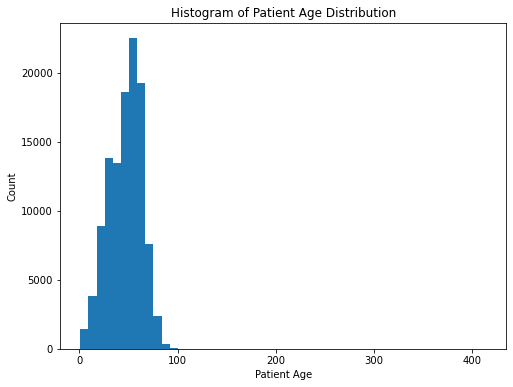

In [9]:
plt.figure(figsize = (8, 6))
_ = plt.hist(all_xray_df['Patient Age'], bins = 50)
plt.xlabel('Patient Age')
plt.ylabel('Count')
plt.title('Histogram of Patient Age Distribution')

all_xray_df['Patient Age'].describe()


When displaying the minimum and maximum ages, it is noticeable that the maximum age is 414 years. There seem to be errors in the data here. The oldest person whose age has been scientifically verified is Frenchwoman Jeanne Calment, who died at the age of 122 years and 164 days. The oldest living person is considered to be Kane Tanaka of Japan, born on January 2, 1903; the title was officially awarded by Guinness World Records on March 9, 2019. The oldest person from German-speaking countries is Augusta Holtz, who emigrated to the United States and died at the age of 115 years and 79 days. The oldest living person from German-speaking countries known by name is Josefine Ollmann of Germany, born on November 11, 1908.

The histogram seems to have a cut at 100 years, so let us have a look at the records and the number of records where the age is above 100.

In [10]:
all_xray_df[all_xray_df['Patient Age']> 100]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139


There must be typos in the data collection process because the age of all these persons seems to be unlikely. Since there are only 16 entries, we will filter them out for now. To draw further conclusions, we need to talk to the hospital that collected this data.

In [11]:
all_xray_df.drop(all_xray_df[(all_xray_df['Patient Age']> 100)].index, inplace=True)

In [12]:
After cleaning the dataset, we arrive at this distribution.

SyntaxError: invalid syntax (<ipython-input-12-cfe57047b1f2>, line 1)

Text(0.5, 1.0, 'Histogram of Patient Age Distribution')

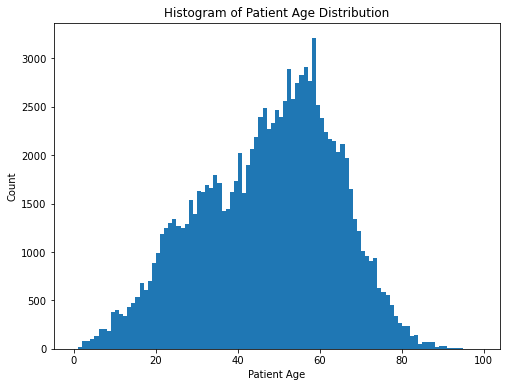

In [13]:
plt.figure(figsize = (8, 6))
_ = plt.hist(all_xray_df['Patient Age'], bins = np.arange(0,100,1))
plt.xlabel('Patient Age')
plt.ylabel('Count')
plt.title('Histogram of Patient Age Distribution')


# Gender distribution of patients

[Text(0.5, 1.0, 'Gender distribution of patients')]

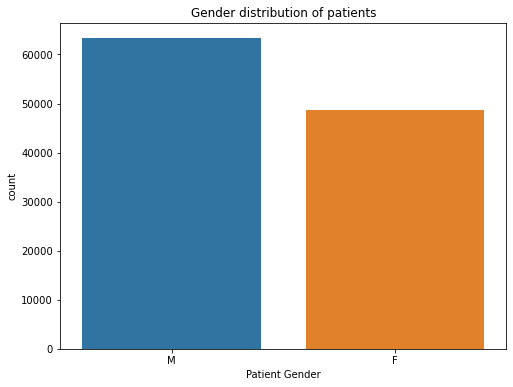

In [14]:
fig = plt.subplots(figsize= (8,6))
sns.countplot(x='Patient Gender', data=all_xray_df).set(title="Gender distribution of patients")

In [15]:
# count the number of males / females
all_xray_df['Patient Gender'].value_counts()

M    63328
F    48776
Name: Patient Gender, dtype: int64

In [16]:
# convert the numbers to percentage
all_xray_df['Patient Gender'].value_counts(normalize= True)

M    0.564904
F    0.435096
Name: Patient Gender, dtype: float64

In the evaluated dataset there are 56.5% male and 43.5% female patients. This ratio should be similar in training and validation data sets.



# Age distribution by gender

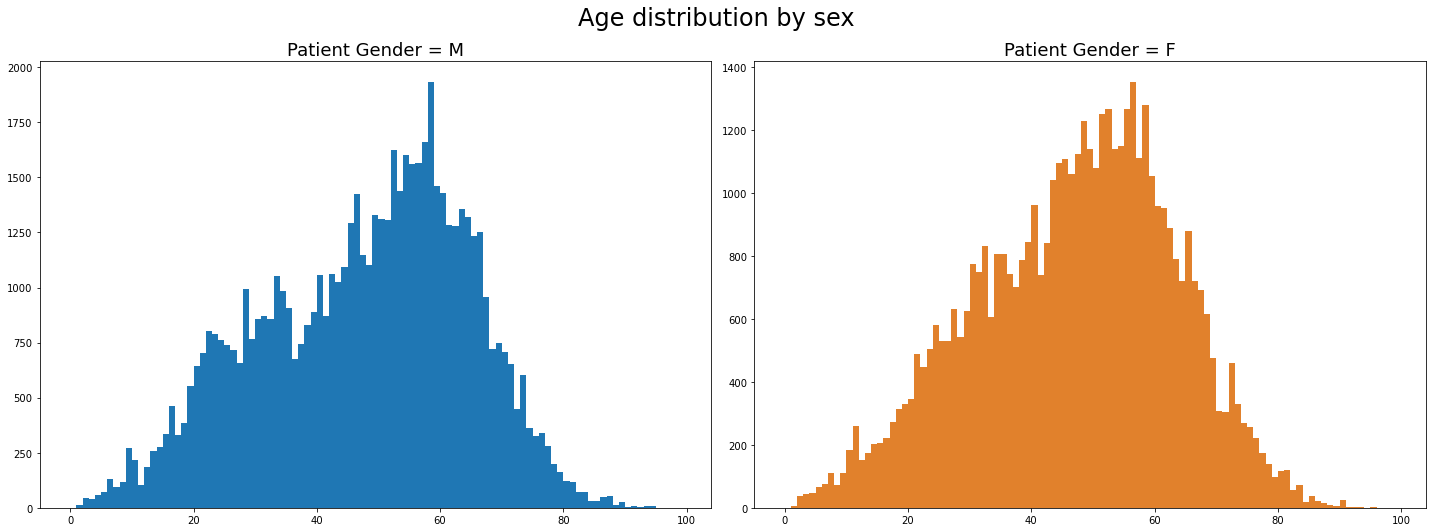

In [44]:
plt.subplot(1,2,1)
plt.hist(all_xray_df['Patient Age'][all_xray_df['Patient Gender']=="M"], bins = np.arange(0,100,1))
plt.title("Patient Gender = M", fontsize=18)
plt.subplot(1,2,2)
plt.hist(all_xray_df['Patient Age'][all_xray_df['Patient Gender']=="F"], bins = np.arange(0,100,1), color="#e1812c")
plt.title("Patient Gender = F", fontsize=18)
plt.suptitle("Age distribution by sex", fontsize=24)
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [20.0, 7.5]
plt.show()



# View Position of images

[Text(0.5, 1.0, 'View Position of images')]

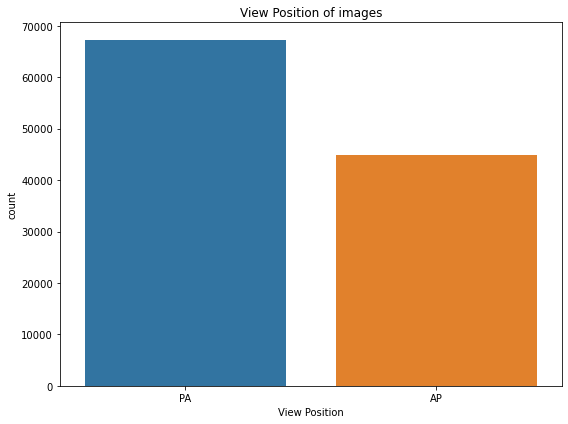

In [18]:
fig = plt.subplots(figsize= (8,6))
sns.countplot(x='View Position', data=all_xray_df).set(title="View Position of images")

In [19]:
all_xray_df['View Position'].value_counts()

PA    67299
AP    44805
Name: View Position, dtype: int64

In [20]:
all_xray_df['View Position'].value_counts(normalize=True)

PA    0.600326
AP    0.399674
Name: View Position, dtype: float64

In a posteroanterior (PA) view, the x-ray source is positioned so that the x-ray beam enters through the posterior (back) aspect of the chest and exits out of the anterior (front) aspect.

In anteroposterior (AP) views, the positions of the x-ray source and detector are reversed: the x-ray beam enters through the anterior aspect and exits through the posterior aspect of the chest.

Almost 60% of X-rays have posteroanterior(PA) view and 40% have anteroposterior (AP) view.

AP chest x-rays are harder to read than PA x-rays and are therefore generally reserved for situations where it is difficult for the patient to get an ordinary chest x-ray, such as when the patient is bedridden.

# Findings

To categorize the findings in the dataset, we use the column "Finding Labels". Since diseases can occur together, several entries are also possible in this column. We use the class chain from the itertools to separate the finding labels after merging into a list and to remove duplicates.


<AxesSubplot:>

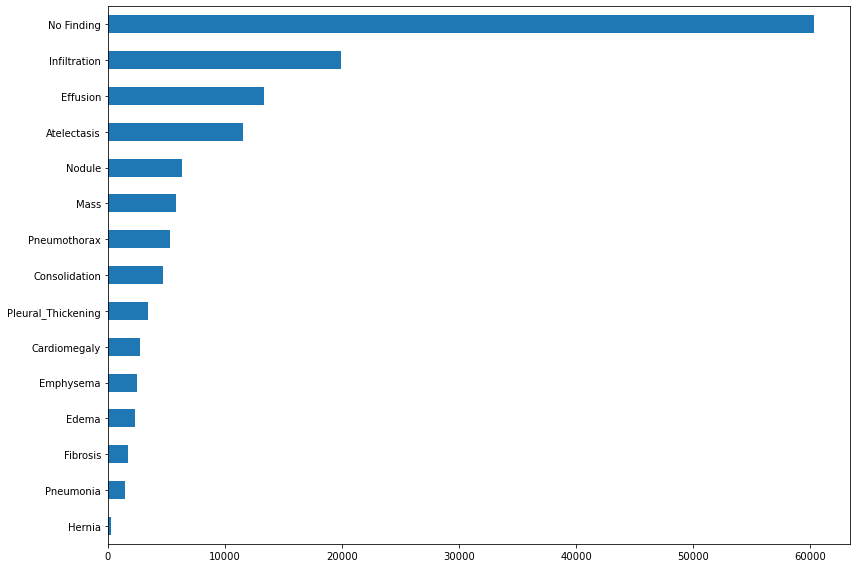

In [21]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].str.split('|').tolist())))
for i in all_labels:
    all_xray_df[i] = all_xray_df['Finding Labels'].map(lambda x : 1 if i in x else 0)

plt.figure(figsize = (12, 8))
all_xray_df[all_labels].sum().sort_values(ascending = True).plot(kind = 'barh')

After the findings have been divided and visualized, the values are now output.

In [22]:
all_xray_df[all_labels].sum().sort_values(ascending = False)

No Finding            60353
Infiltration          19891
Effusion              13316
Atelectasis           11558
Nodule                 6331
Mass                   5779
Pneumothorax           5301
Consolidation          4667
Pleural_Thickening     3384
Cardiomegaly           2776
Emphysema              2516
Edema                  2302
Fibrosis               1686
Pneumonia              1430
Hernia                  227
dtype: int64

Now the values are checked again with regard to pneumonia and the percentage is determined.

In [23]:
all_xray_df['Pneumonia'].value_counts()

0    110674
1      1430
Name: Pneumonia, dtype: int64

In [24]:
all_xray_df['Pneumonia'].value_counts(normalize=True)

0    0.987244
1    0.012756
Name: Pneumonia, dtype: float64

The result of the study is that only 1.2% of all x-rays show pneumonia.

In [25]:
all_xray_df['No Finding'].value_counts(normalize=True)

1    0.538366
0    0.461634
Name: No Finding, dtype: float64

The result of the study is that almost 54% of all x-rays show no findings.

# Pneumonia cases

As shown in the previous section, we have 1430 cases with pneumonia, which are 1.2% of all x-rays.

In this section, we show the number of pneumonia cases associated with other lung diseases. Since there are many individual cases of pneumonia associated with another disease, we will reduce the output to the top 20 cases.

In [80]:
all_pneumonia_df = all_xray_df[all_xray_df['Pneumonia']==1]
all_pneumonia_df['Finding Labels'].value_counts()[0:20]

Pneumonia                                      322
Infiltration|Pneumonia                         199
Edema|Infiltration|Pneumonia                   137
Atelectasis|Pneumonia                          108
Edema|Pneumonia                                 83
Effusion|Pneumonia                              53
Effusion|Infiltration|Pneumonia                 42
Consolidation|Pneumonia                         36
Atelectasis|Infiltration|Pneumonia              34
Atelectasis|Effusion|Pneumonia                  23
Edema|Effusion|Infiltration|Pneumonia           21
Nodule|Pneumonia                                19
Edema|Effusion|Pneumonia                        19
Atelectasis|Effusion|Infiltration|Pneumonia     18
Atelectasis|Consolidation|Pneumonia             15
Consolidation|Infiltration|Pneumonia            13
Mass|Pneumonia                                  11
Pleural_Thickening|Pneumonia                    11
Infiltration|Nodule|Pneumonia                   11
Consolidation|Effusion|Pneumoni

In [28]:
all_pneumonia_df['Patient Age'].describe()

count    1430.000000
mean       44.670629
std        17.639098
min         2.000000
25%        31.000000
50%        46.000000
75%        59.000000
max        90.000000
Name: Patient Age, dtype: float64

# Non-pneumonia cases

Logically, all cases that do not have pneumonia must be the counter set to pneumonia cases. We can now either subtract the pneumonia cases from the total cases or attempt another evaluation. To get to know more functions in Python, I implement another evaluation: 

In [29]:
all_xray_df.groupby('Pneumonia')['Pneumonia'].count()


Pneumonia
0    110674
1      1430
Name: Pneumonia, dtype: int64

So we can easily see, that we have 110674 non-pneumonia and 1430 pneumonia cases in the dataset.

# Age distribution of pneumonia cases

In this section we want to have a look at the age distribution of pneumonia cases.


In [30]:
all_xray_df.groupby('Pneumonia')['Patient Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Pneumonia,,,,,,,,
0,110674.0,46.901025,16.582446,1.0,35.0,49.0,59.0,95.0
1,1430.0,44.670629,17.639098,2.0,31.0,46.0,59.0,90.0


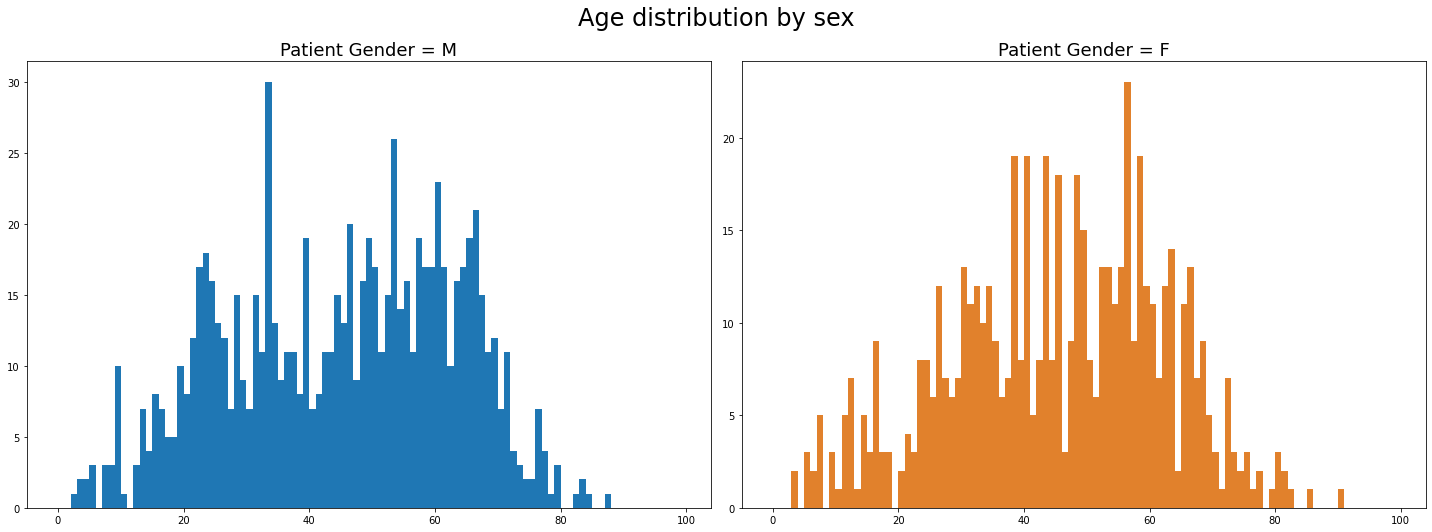

In [46]:
plt.subplot(1,2,1)
plt.hist(all_xray_df['Patient Age'][all_xray_df['Patient Gender']=="M"][all_xray_df['Pneumonia']==1], bins = np.arange(0,100,1))
plt.title("Patient Gender = M", fontsize=18)
plt.subplot(1,2,2)
plt.hist(all_xray_df['Patient Age'][all_xray_df['Patient Gender']=="F"][all_xray_df['Pneumonia']==1], bins = np.arange(0,100,1), color="#e1812c")
plt.title("Patient Gender = F", fontsize=18)
plt.suptitle("Age distribution by sex", fontsize=24)
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [20.0, 7.5]
plt.show()

It can be seen very well that the age distribution for men with pneumonia is different from that for women. We regroup the age groups in the next diagram. It becomes clear that there is a peak in men at the age of 60, whereas women show a plateau in the age group 40-65.

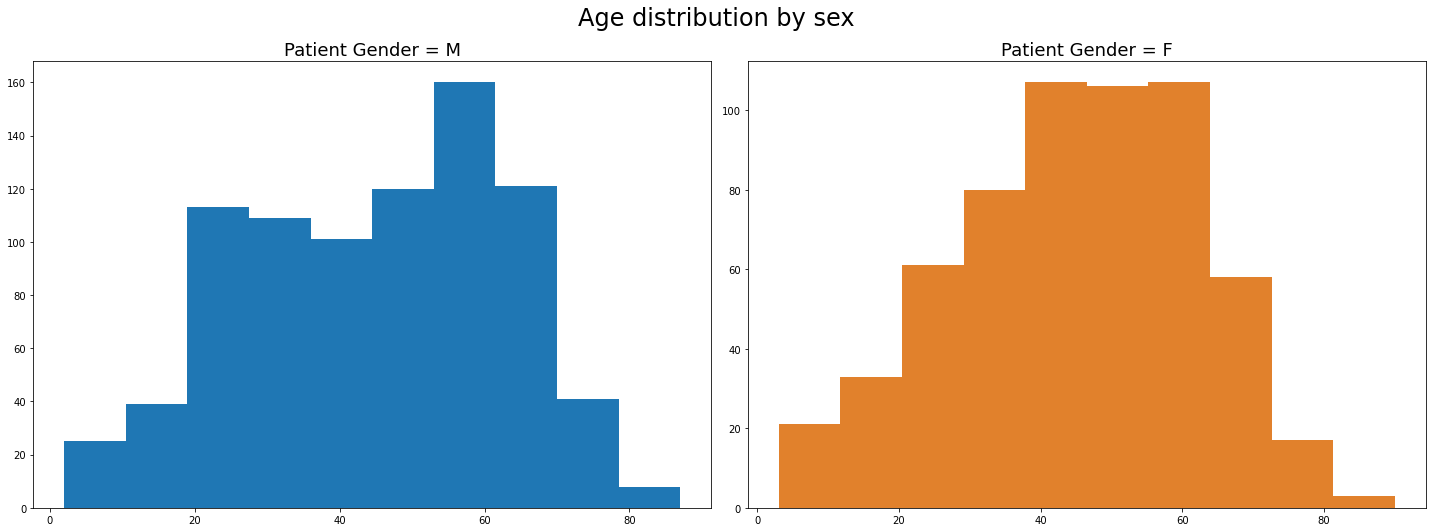

In [47]:
plt.subplot(1,2,1)
plt.hist(all_xray_df['Patient Age'][all_xray_df['Patient Gender']=="M"][all_xray_df['Pneumonia']==1], bins = 10)
plt.title("Patient Gender = M", fontsize=18)
plt.subplot(1,2,2)
plt.hist(all_xray_df['Patient Age'][all_xray_df['Patient Gender']=="F"][all_xray_df['Pneumonia']==1], bins = 10, color="#e1812c")
plt.title("Patient Gender = F", fontsize=18)
plt.suptitle("Age distribution by sex", fontsize=24)
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [20.0, 7.5]
plt.show()

# Gender distribution of pneumonia cases

In this section, we determine the gender distribution between pneumonia patients.

[Text(0.5, 1.0, 'Pneumonia distribution')]

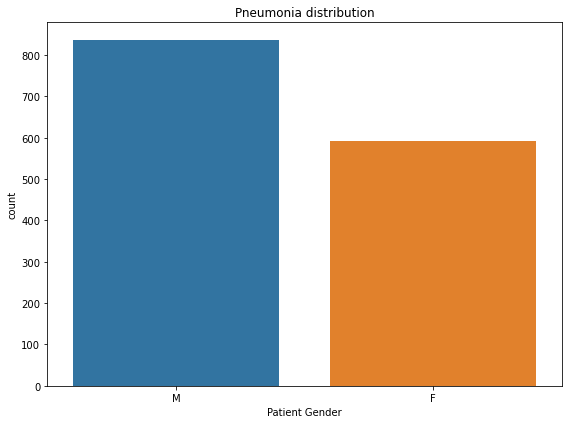

In [32]:
fig = plt.subplots(figsize= (8,6))
sns.countplot(x='Patient Gender', data=all_pneumonia_df).set(title="Pneumonia distribution")

As can be seen clearly from the diagram, male patients predominate in the data set. The next step determines the percentage distribution between men and women which is to be found at 58% men with pneumonia and 42% women with pneumonia.

In [33]:
all_pneumonia_df['Patient Gender'].value_counts(normalize=True)

M    0.585315
F    0.414685
Name: Patient Gender, dtype: float64

# Diseases in correlation with pneumonia

We already created a list of all findings some sections ago. We will use this list to plot a correlation matrix between all diseases.


In [34]:
# make a list from all the diseases...
all_diseases = all_labels.tolist()

# remove the "No Findings" as we do not need it
all_diseases.remove("No Finding")

# ...and to the correlation matrix
corr = all_xray_df[all_diseases].corr()
corr

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Atelectasis,1.000000,0.015817,0.108945,-0.003379,0.172462,0.032598,0.011128,0.010830,0.093157,0.018995,-0.007972,0.025221,0.029948,0.031437
Cardiomegaly,0.015817,1.000000,0.015355,0.028331,0.130096,-0.007093,0.004834,0.001761,0.014191,-0.010670,-0.012128,0.009126,0.002859,-0.022249
Consolidation,0.108945,0.015355,1.000000,0.020835,0.101130,-0.000526,0.003233,-0.005414,0.045931,0.074610,0.031812,0.028742,0.025257,0.000487
Edema,-0.003379,0.028331,0.020835,1.000000,0.062127,-0.009200,-0.013241,-0.002325,0.094265,0.002939,0.000271,-0.002018,0.174110,-0.022479
Effusion,0.172462,0.130096,0.101130,0.062127,1.000000,0.011195,-0.002779,-0.003658,0.118164,0.070770,0.019109,0.072037,0.024112,0.047587
Emphysema,0.032598,-0.007093,-0.000526,-0.009200,0.011195,1.000000,-0.000910,-0.001466,0.000406,0.023232,-0.007067,0.026416,-0.004880,0.178194
Fibrosis,0.011128,0.004834,0.003233,-0.013241,-0.002779,-0.000910,1.000000,0.007477,0.008796,0.009972,0.022474,0.053590,-0.006862,0.000095
Hernia,0.010830,0.001761,-0.005414,-0.002325,-0.003658,-0.001466,0.007477,1.000000,-0.003780,0.011934,-0.002424,0.001331,0.000185,-0.001621
Infiltration,0.093157,0.014191,0.045931,0.094265,0.118164,0.000406,0.008796,-0.003780,1.000000,0.013898,0.042754,0.020411,0.073088,0.000597
Mass,0.018995,-0.010670,0.074610,0.002939,0.070770,0.023232,0.009972,0.011934,0.013898,1.000000,0.101300,0.065206,-0.000977,0.029980


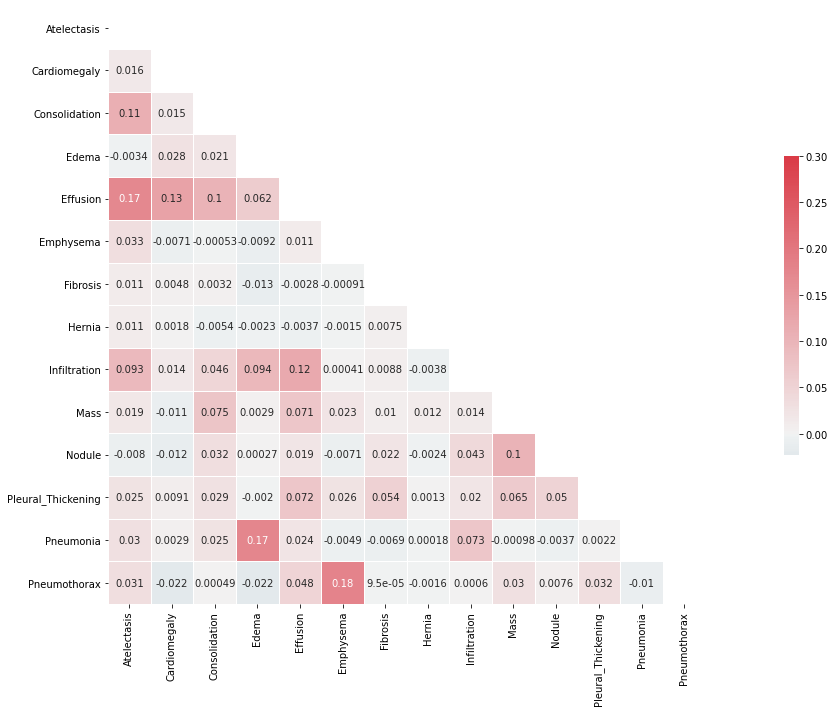

In [35]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,annot=True, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

After we found out about the correlation between all diseases, let's examin ethe correlation between pneumonia and other diseases in detail

<AxesSubplot:title={'center':'Correlation with Pneumonia'}>

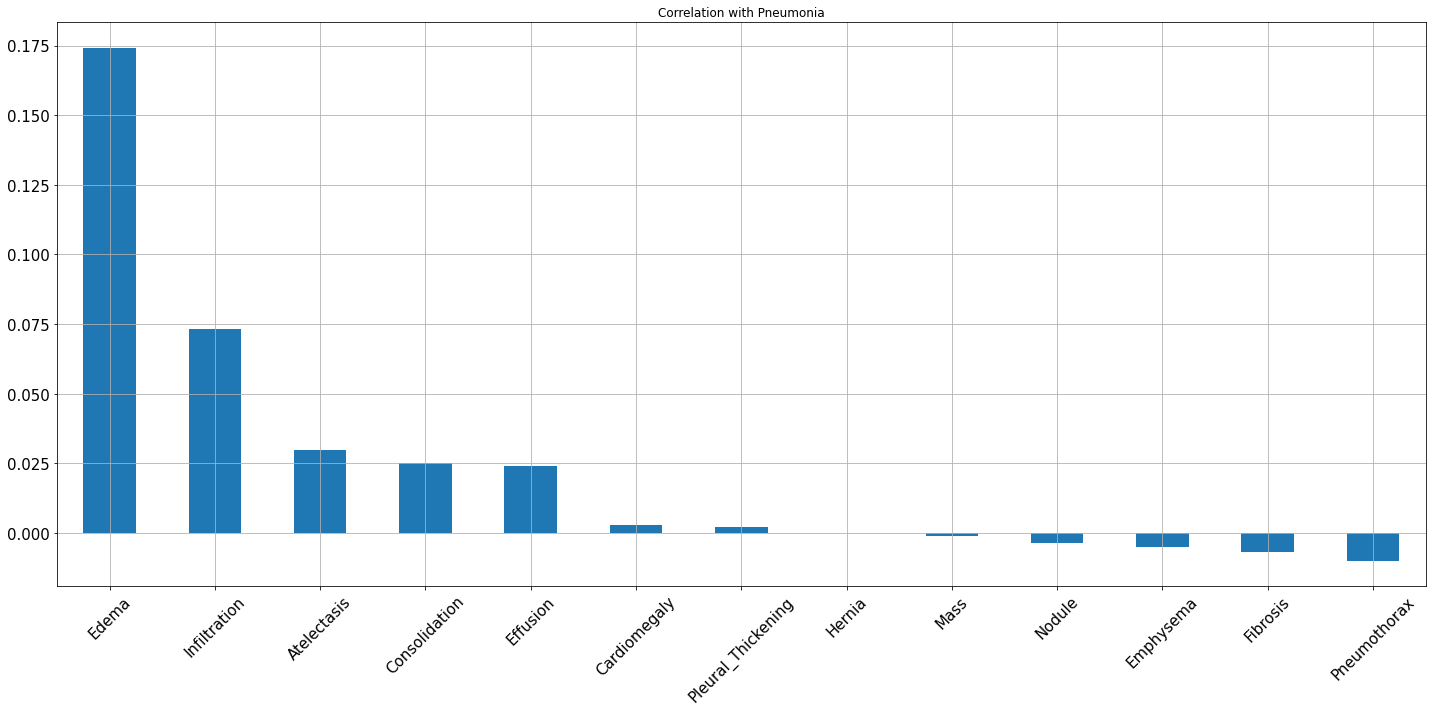

In [36]:
other_diseases = all_diseases[:]
other_diseases.remove("Pneumonia")
all_xray_df[other_diseases].corrwith(all_xray_df['Pneumonia']).sort_values(ascending=False).plot.bar(figsize=(20,10),
                  title = 'Correlation with Pneumonia',
                  fontsize = 15, rot = 45,
                  grid = True)

We clearly can see, that pneumonia has a correlation with edema and infiltration


# Number of diseases per patient

It is not clearly specified how diseases per patient should be measured. If I take all rows of the dataset and calculate the mean of diseases per patient, the value is 0.724. This includes also patients who have no finding.

If I only take the rows of the dataset into account where the patient has a finding, the mean is 1.568

Patients with no findings have per default no disease, so this value is 0.0

In [60]:
all_xray_df['Total Disease Count'].mean()

0.7240062798829658

In [58]:
all_xray_df['Total Disease Count'][all_xray_df['No Finding']==0].mean()

1.5683561670305888

In [59]:
all_xray_df['Total Disease Count'][all_xray_df['No Finding']==1].mean()

0.0

# Pixel level assessment

I downloaded the folder images_001 from the proposed kaggle website for pixel assessment. I used the list with all diseases created in a former section to get a picture for each disease and did a corresponding histogram for the picture.


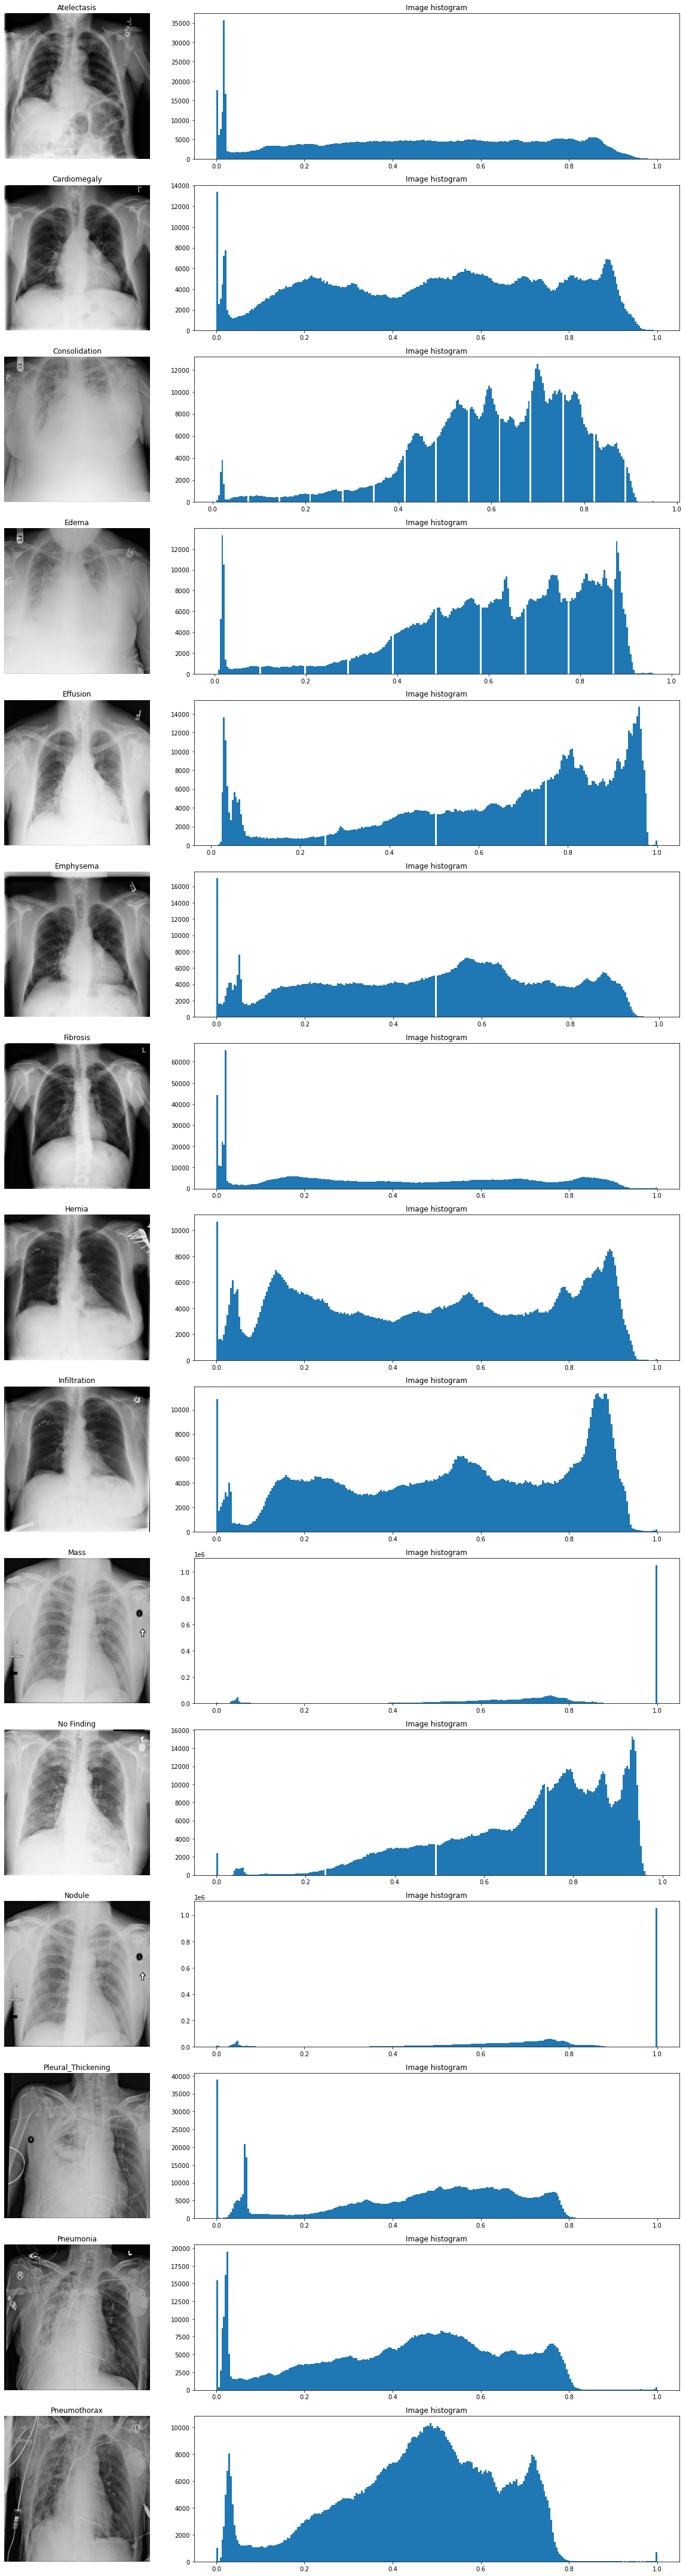

In [73]:
path = "./data/images_001/images/"
fig, axs = plt.subplots(len(all_labels), 2, figsize = (20, 60))
i = 0
for disease in all_labels:
    img_name = all_xray_df[all_xray_df[disease] == 1]['Image Index'].reset_index(drop = True)[0]
    img_path = os.path.join(path, img_name)
    if not os.path.exists(img_path):  continue
    img = plt.imread(path + img_name)
    axs[i, 0].imshow(img, cmap = 'gray')
    axs[i, 0].set_title(disease)
    axs[i, 1].hist(img.ravel(), bins = 256)
    axs[i, 1].set_title('Image histogram')
    axs[i, 0].axis('off')
    i += 1

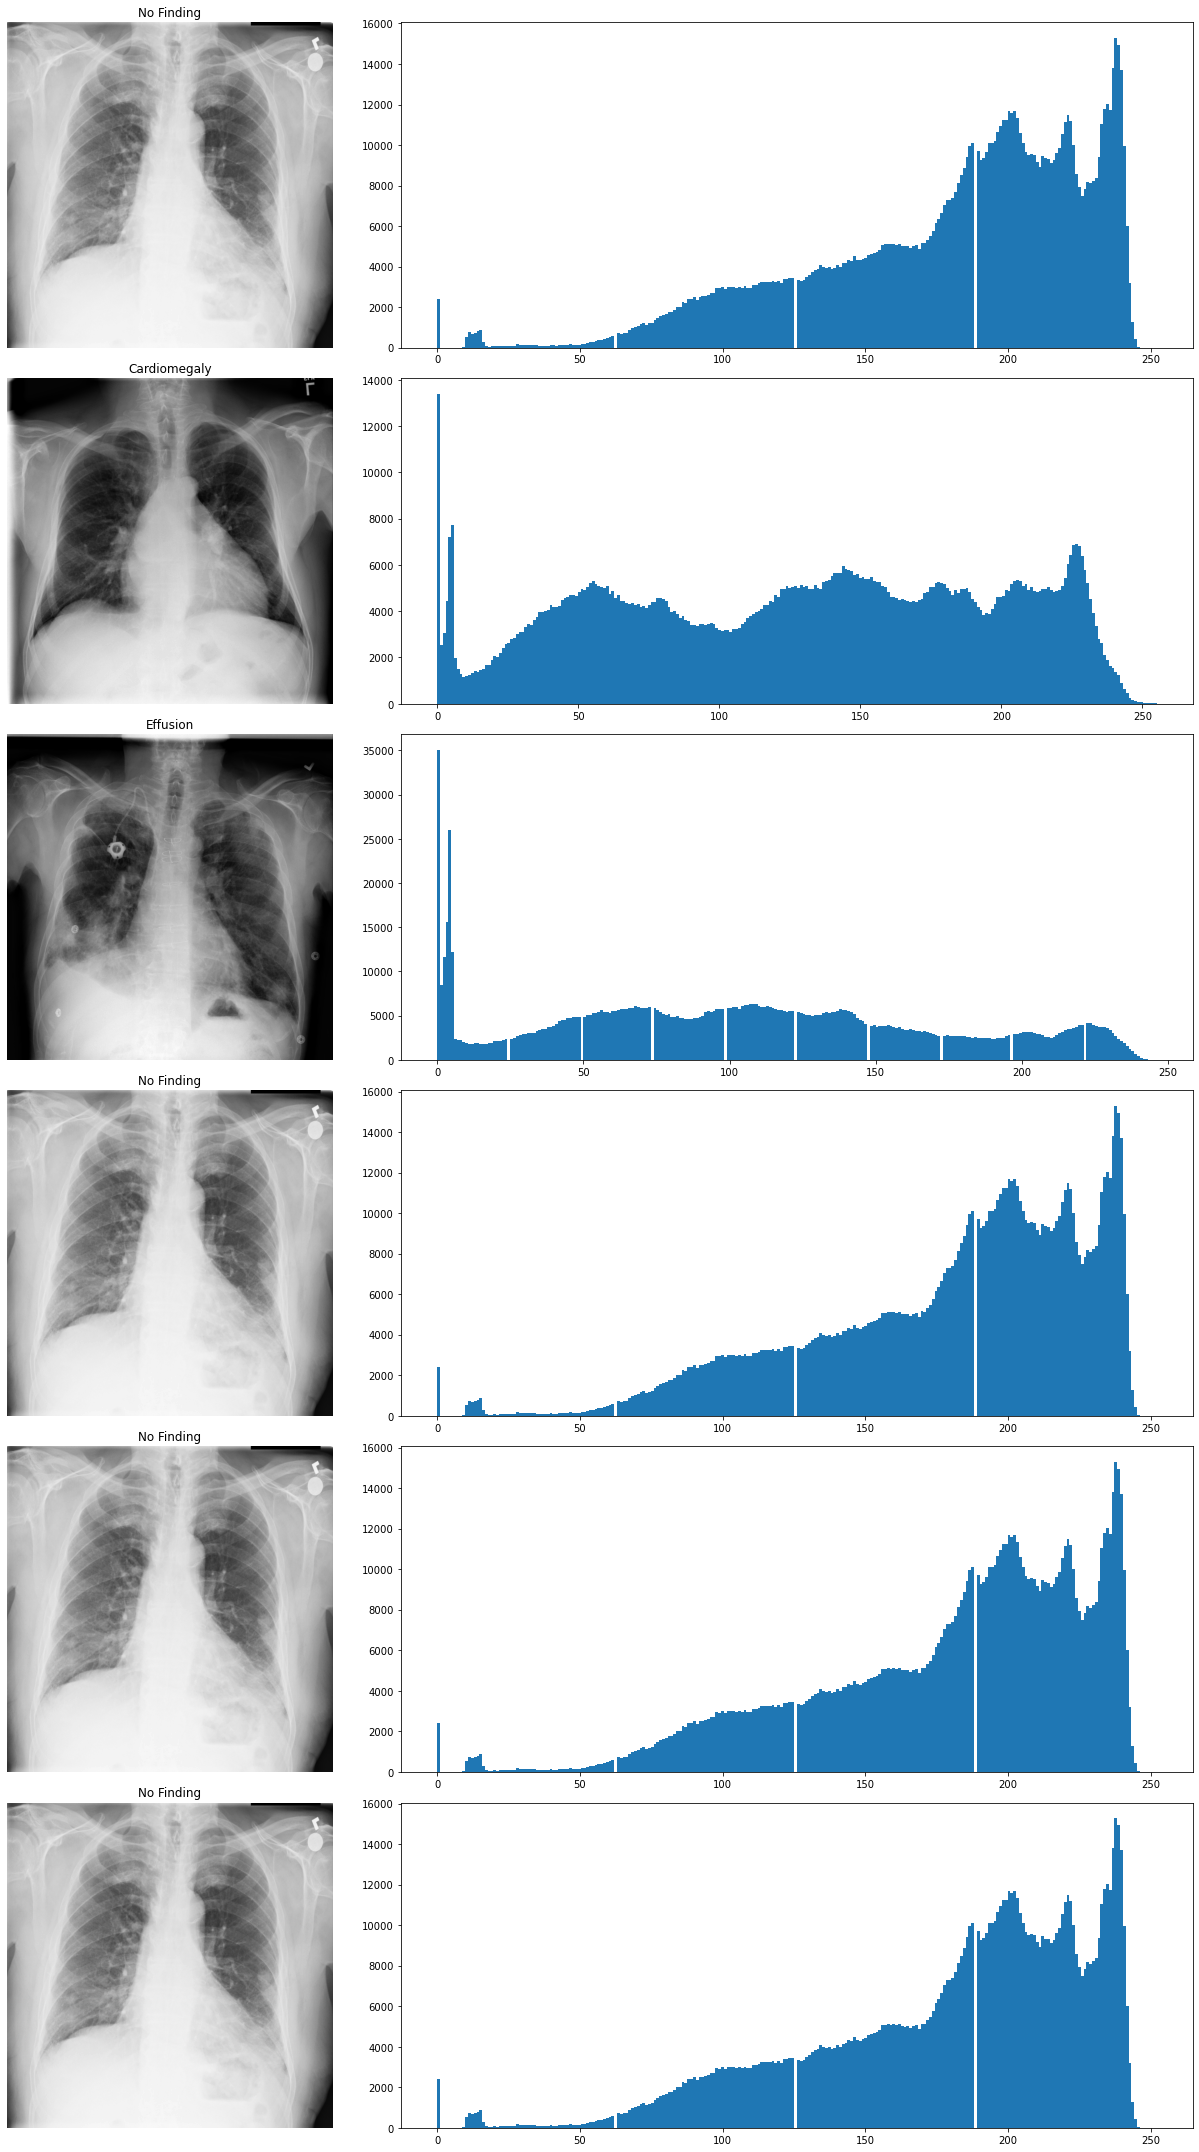

In [70]:
img_list = glob('*.dcm')

fig, axs = plt.subplots(len(img_list), 2, figsize = (20, 30))
for i, path in enumerate(img_list):
    dcm = pydicom.dcmread(path)
    label = dcm.StudyDescription
    axs[i, 0].imshow(dcm.pixel_array, cmap = 'gray')
    axs[i, 0].set_title(label)
    axs[i, 1].hist(dcm.pixel_array.ravel(), bins = 256)
    axs[i, 0].axis('off')

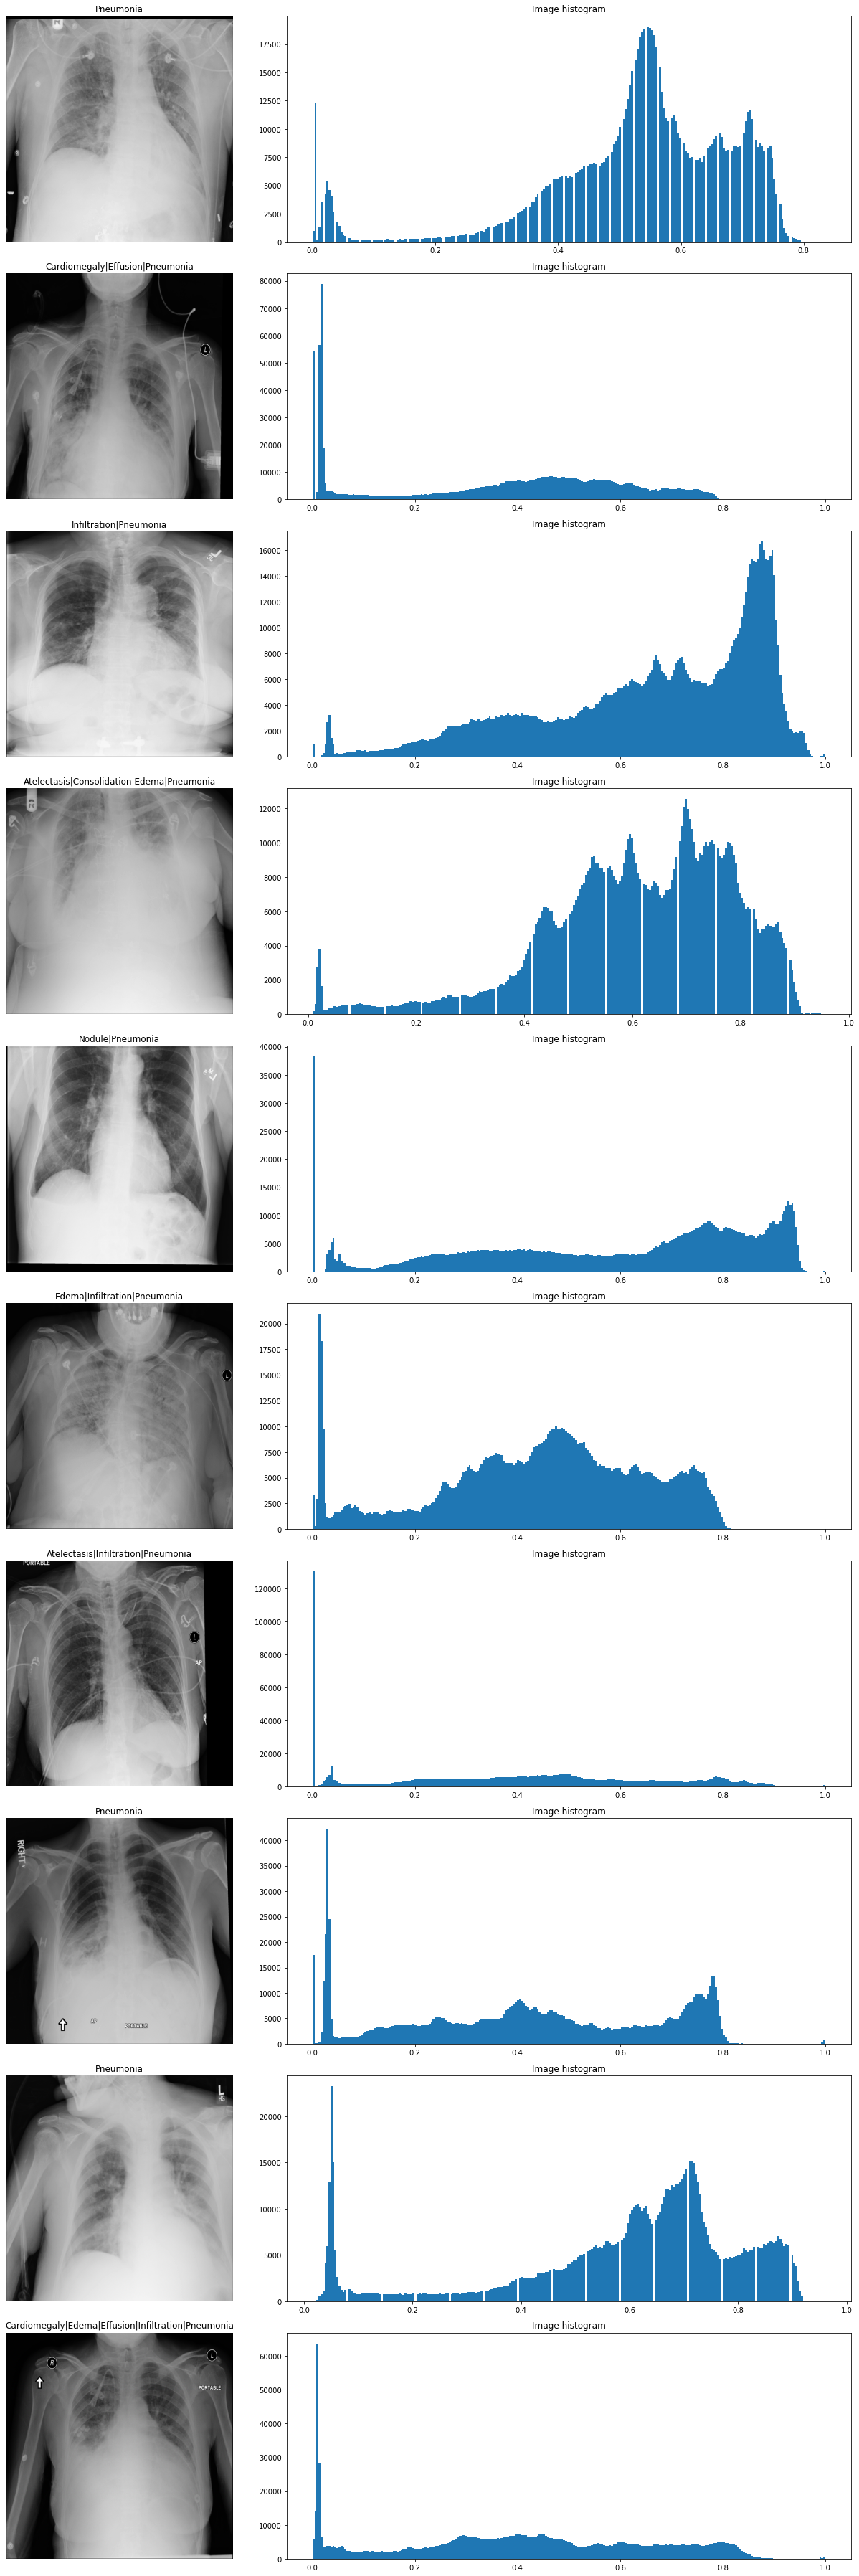

In [74]:
path = "./data/images_001/images/"
fig, axs = plt.subplots(10, 2, figsize = (20, 50))
i = 0
for idx, row in all_pneumonia_df[:20].sample(10).iterrows():
    img_path = os.path.join(path, row['Image Index'])
    if not os.path.exists(img_path):  continue
    img = plt.imread(img_path)
    label = row['Finding Labels']
    axs[i, 0].imshow(img, cmap = 'gray')
    axs[i, 0].set_title(label)
    axs[i, 1].hist(img.ravel(), bins = 256)
    axs[i, 1].set_title('Image histogram')
    axs[i, 0].axis('off')
    i += 1

# Distribution between Pneumonia and non Pneumonia

In the vast majority of cases, it can be seen that the density distribution of pneumonia cases has a cut off at approximately 0.8. This is in contrast to the images without findings, which usually have a density distribution of up to 1.0. We try to show this with the following code fragment, which pulls from the images_001 dataset any pneumonia image and any image without finding.

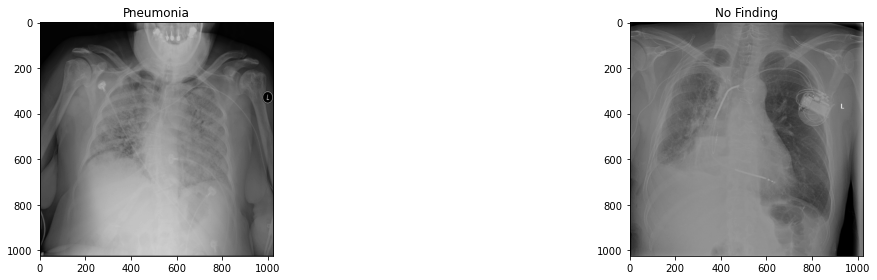

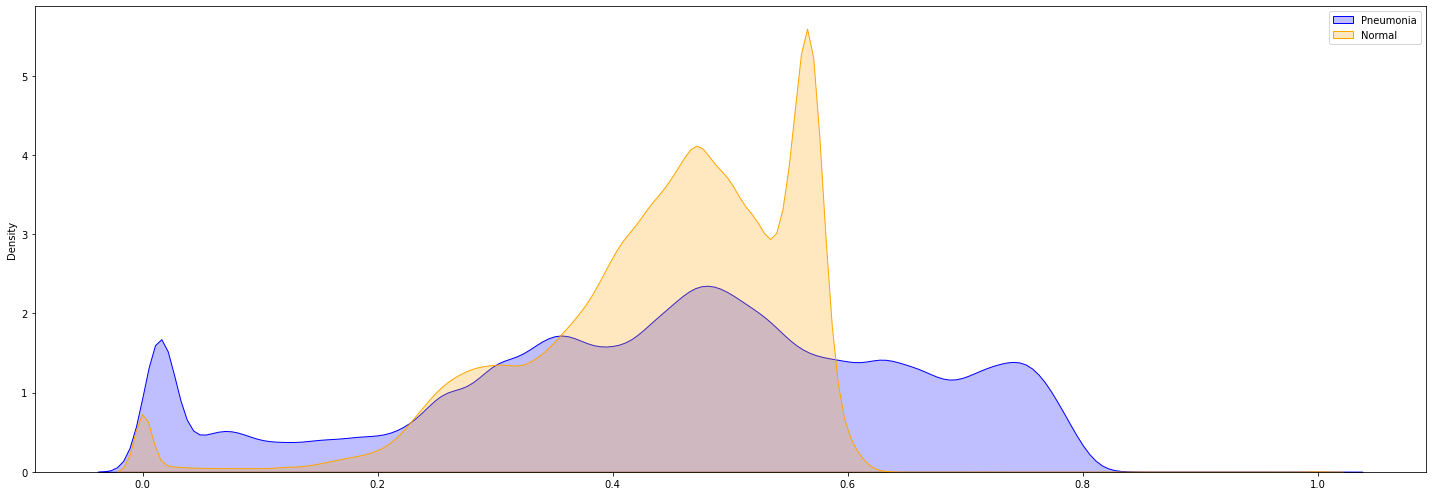

In [125]:
f = plt.figure()
f.set_figwidth(20)

for idx, row in all_pneumonia_df[:20].sample(10).iterrows():
    img_path = os.path.join(path, row['Image Index'])
    if not os.path.exists(img_path):  continue
    img_pneu = plt.imread(img_path)
    break

s1 = f.add_subplot(1,2,1)
s1.set_title("Pneumonia")
plt.imshow(img_pneu, cmap='gray')


for idx, row in no_pneumonia_df[:20].sample(10).iterrows():
    img_path = os.path.join(path, row['Image Index'])
    if not os.path.exists(img_path):  continue
    img_nf = plt.imread(img_path)
    break
    
s2 = f.add_subplot(1,2,2)
s2.set_title("No Finding")    
plt.imshow(img_nf, cmap='gray')

plt.show()

plt.figure(figsize=(20,7))
sns.kdeplot(img_pneu.ravel(), color='blue', shade=True, label='Pneumonia')
sns.kdeplot(img_nf.ravel(), color='orange', shade=True, label='Normal');
plt.legend()

# Key Findings 

- The patient's ages are normally distributed. There are some outliers in patient age in the range of 150-400 years. These rows have been filtered out.
- The dataset is highly imbalanced for Pneumonia.
- Pneumonia cases are the second lowest in the dataset. 
- Age group 55-65 seems to have highest number of Pneumonia cases for both male and female.
- There are more number of male patients with Pneumonia than females.
- Infiltration and Edema seems to be two most occuring diseases with Pneumonia.
- The highest brightness can be found in "No Finding" images
- Pneumonia images seem to have a cutoff at ca 200, from 200-255